In [1]:
import sys, os
import importlib
from importlib import reload
# importlib.import_module(module_name)
from collections import namedtuple

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import tqdm
import joblib

sys.path.append("../../../python")
from simhelper import util, root, generator, parser
from simhelper import datatypes
from simhelper import helper_basic as hp
from simhelper import helper_plt as hplt
reload(parser)
reload(datatypes)

sys.path.append("..")
import cut_functions
reload(cut_functions)

np.set_printoptions(edgeitems=30, linewidth=100000, 
    precision=3)

# Plot settings
reload(hplt)
hplt.plt_config() # Default plotting styles
%config InlineBackend.figure_format='retina'
save_fig = hplt.Save_fig(fig_prefix="plots/", exts="pdf,jpg",dpi=200,SAVE=True)

Welcome to JupyROOT 6.28/10


In [4]:
data_dir="/home/tomren/geant_projects/musim_test/"

In [56]:
def process_trigger(file, entries=-1):
    # Get metadata
    file.get_tree("metadata_digi")
    metadata_digi = file.get_entry(0)
    
    # Get data
    file.get_tree("data;1")
    print("Entries", file.entries)


    # Make a container
    keys = ["n_layer","n_quarterlayer", "n_tower","event_idx"]
    data = {key:[] for key in keys}

    if entries==-1:
        entries = file.entries    
    entries = min(entries, file.entries )
    
    for i in range(entries):
        root_data = file.get_entry(i)
        # event = datatypes.Event(root_data, metadata_digi, parse_truth=False, detector_efficiency = 1, min_nhits=4)
        detids = np.array(root_data["Digi_detectorID"])
        # i_det = detids//1000_000_00000
        # i_tower = detids%1000_000_00000
        # i_layer = detids%1_000_00000
        # i_bar = detids%1_00000

        id_layer_group = detids//1_00000
        id_quarterlayer_group = detids//1_00000*1_00000 + detids%1_00000//(900//3.5/8)
        id_tower_group = detids//1_000_00000

        _, unique_layer_counts = np.unique(id_layer_group,return_counts=True)
        _, unique_quarterlayer_counts = np.unique(id_quarterlayer_group,return_counts=True)
        _, unique_tower_counts = np.unique(id_tower_group,return_counts=True)
        
        # return unique_layer_counts, unique_quarterlayer_counts
        # data["n_layer"].extend(unique_layer_counts)
        # data["n_quarterlayer"].extend(unique_quarterlayer_counts)
        # data["n_tower"].extend(unique_tower_counts)
        data["n_layer"].append(max(unique_layer_counts))
        data["n_quarterlayer"].append(max(unique_quarterlayer_counts))
        data["n_tower"].append(max(unique_tower_counts)        )

    return data

In [57]:
signal_mass_list = [15, 25, 35, 45, 55]

data_all = {}
for mx in signal_mass_list[:]:
    print(mx)
    fname_sig1 =   f"{data_dir}/llp_hxx_bb/run_{mx}_digi_cosmic_recon_skim.root"
    fsig1 = root.tfile_reader(fname_sig1)
    fsig1.get_tree("data;1")
    print(f"Mass {mx} GeV, Entries", fsig1.entries)

    data = process_trigger(fsig1, entries=2000)
    data_all[mx] = data

15
Mass 15 GeV, Entries 8765
Entries 8765
25
Mass 25 GeV, Entries 9172
Entries 9172
35
Mass 35 GeV, Entries 9181
Entries 9181
45
Mass 45 GeV, Entries 9120
Entries 9120
55
Mass 55 GeV, Entries 8986
Entries 8986


Fraction of layer with >32 digits: 0.139
Fraction of bar assembly with >16 digits: 0.065
Fraction of tower with >90 digits: 0.36


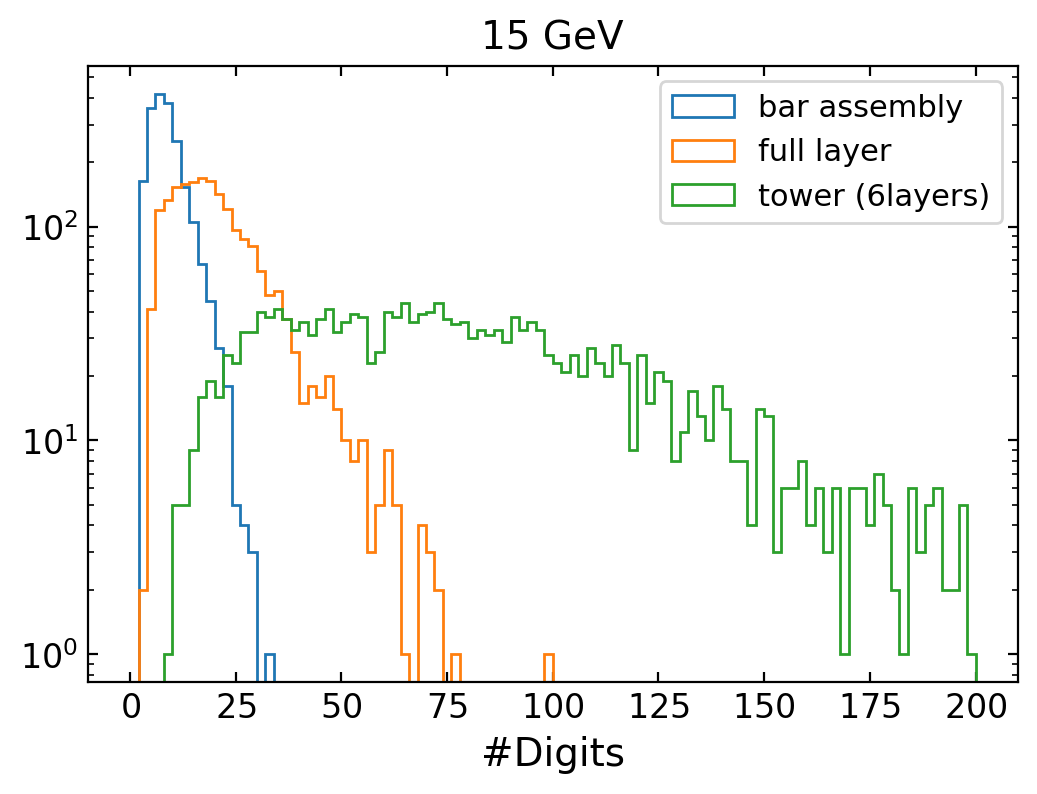

Fraction of layer with >32 digits: 0.113
Fraction of bar assembly with >16 digits: 0.0495
Fraction of tower with >90 digits: 0.3115


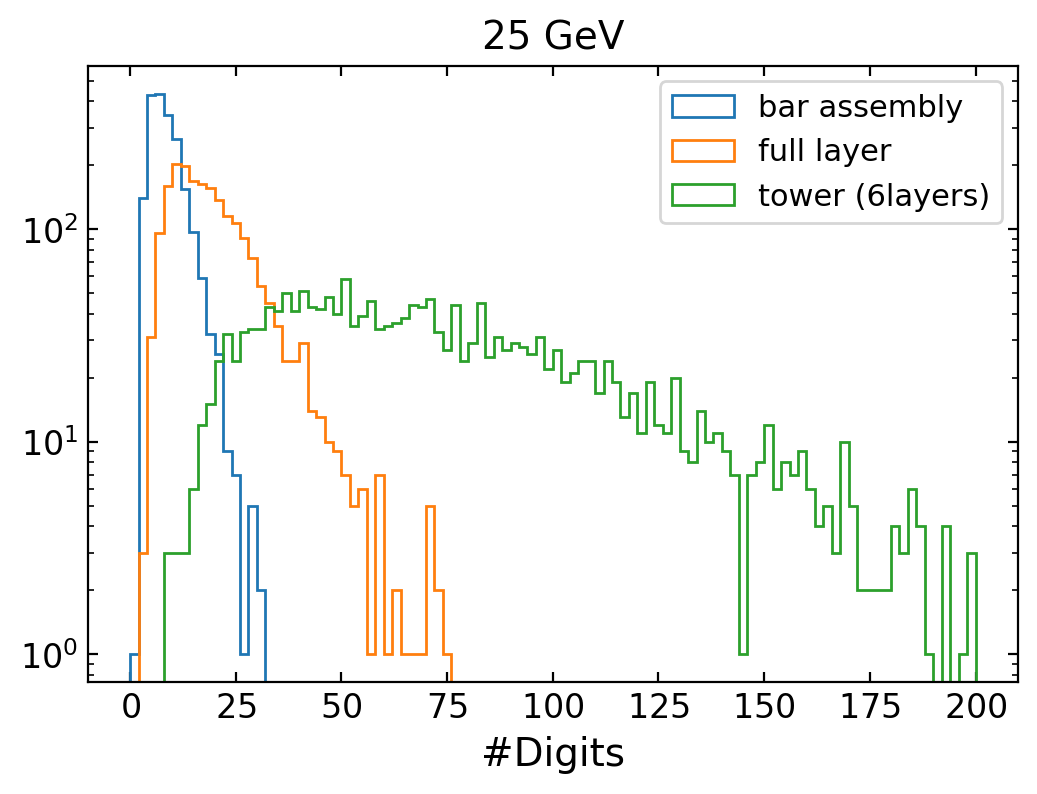

Fraction of layer with >32 digits: 0.107
Fraction of bar assembly with >16 digits: 0.055
Fraction of tower with >90 digits: 0.2855


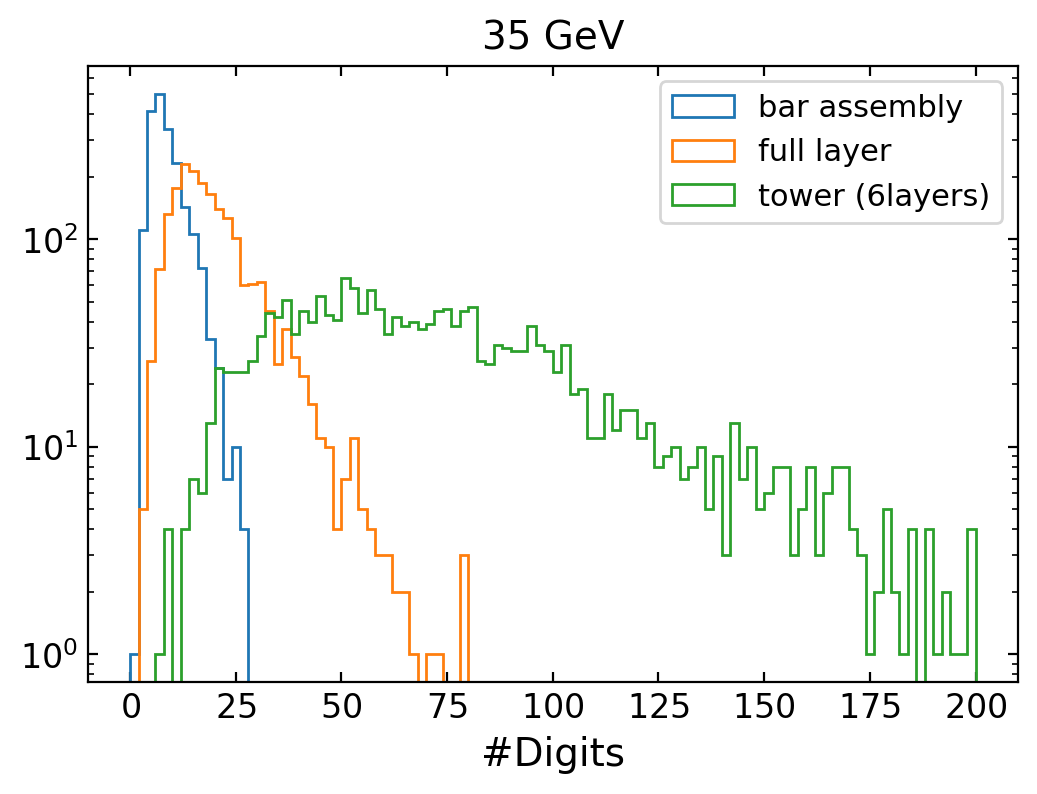

Fraction of layer with >32 digits: 0.114
Fraction of bar assembly with >16 digits: 0.0445
Fraction of tower with >90 digits: 0.2635


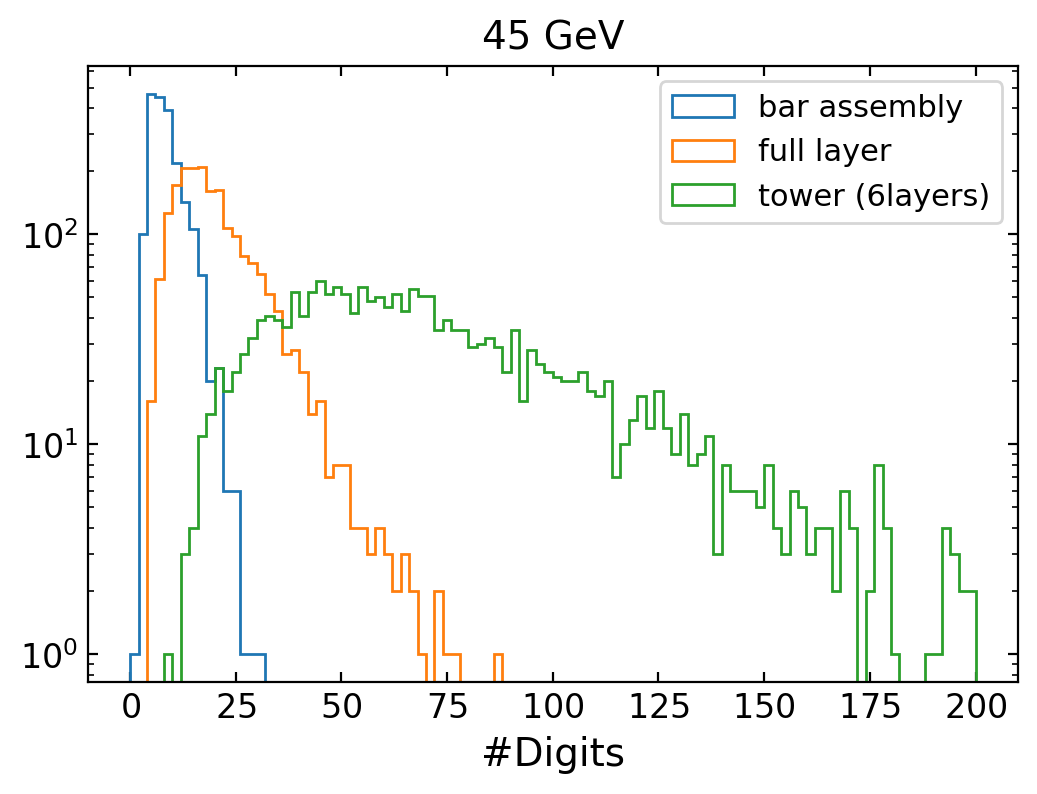

Fraction of layer with >32 digits: 0.131
Fraction of bar assembly with >16 digits: 0.0445
Fraction of tower with >90 digits: 0.2355


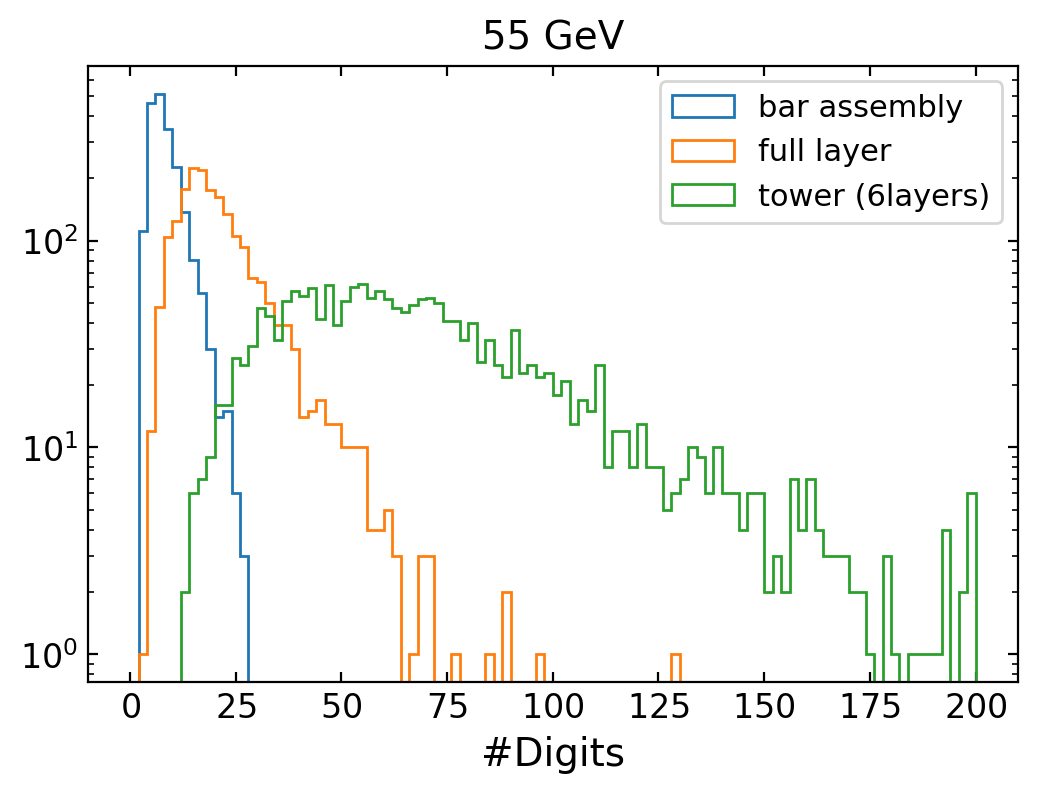

In [59]:
for mx in data_all:
    data =     data_all[mx]
    plt.hist(data["n_quarterlayer"],bins=100, range=(0,200),histtype="step", label="bar assembly");
    plt.hist(data["n_layer"],bins=100, range=(0,200),histtype="step", label="full layer");
    plt.hist(data["n_tower"],bins=100, range=(0,200),histtype="step", label="tower (6layers)");
    plt.yscale("log")
    plt.title(f"{mx} GeV")
    plt.xlabel("#Digits")
    plt.legend()
    print("Fraction of layer with >32 digits:", sum(np.array(data["n_layer"])>32)/len(data["n_layer"]))
    print("Fraction of bar assembly with >16 digits:", sum(np.array(data["n_quarterlayer"])>16)/len(data["n_layer"]))
    print("Fraction of tower with >90 digits:", sum(np.array(data["n_tower"])>90)/len(data["n_layer"]))
    plt.show()